In [56]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib import cm
import multiprocessing as mp
from stitch import stitch

In [57]:
#Constructing a bump function for nvec_h and nvec_f
def bump(left_n, right_n, center, radius, S):
    left = left_n * np.ones(center - radius)
    right = right_n * np.ones(S - center - radius - 1)
    mean = (left_n + right_n) / 2
    middle = (right_n - mean) * np.sin(np.pi * (np.arange(center - radius, center + radius + 1) - center) / (2 * radius)) + mean
    n_vec = np.concatenate((left, middle, right))
    return n_vec

In [58]:
# Assume Cobb-Douglas. Generalized later. 

# Household parameters
life = 100
S = 100
working = round(9 * S / 16)
beta_annual = .96
beta = beta_annual ** (life / S)
sigma = 3.0

theta_h = 0.25
theta_f = 0.35

nvec_h = bump(1.0, 0.2, working, 5, S)
nvec_f = bump(1.0, 0.2, working, 5, S)

L_h = np.sum(nvec_h)
L_f = np.sum(nvec_f)

# Firm parameters
Z_h = 1.4
Z_f = 1.0

gamma_h = .35
gamma_f = .45

delta_annual_h = .05
delta_h = 1 - ((1 - delta_annual_h) ** (life / S))

delta_annual_f = .07
delta_f = 1 - ((1 - delta_annual_f) ** (life / S))

# SS parameters
SS_tol = 1e-13
xi = 0.6

In [59]:
@stitch(lambda cvec, sigma: -sigma / (cvec ** (1 + sigma)), (0, None), 1e-5)
def get_MUvec(cvec, sigma):
    return 1 / (cvec ** sigma)

@stitch(lambda x, gamma: gamma / (x ** (1 - gamma)), (0, None), 1e-5)
def root(x, gamma):
    return x ** gamma

def get_K(r, L, Z, P, gamma, delta):
    return (gamma * Z * P * (L ** (1 - gamma)) / (r + delta)) ** (1 / (1 - gamma))

def get_r(K, L, Z, P, gamma, delta):
    return gamma * Z * P * root(L, (1 - gamma)) * root(K, (gamma - 1)) - delta

def get_w(K, L, Z, P, gamma):
    return (1 - gamma) * Z * P * ((K / L) ** gamma)

def get_P(theta, P_1, P_2, e):
    constant = ((1 - theta) ** (1 - theta)) * (theta ** theta)
    return (1 / constant) * (P_1 ** (1 - theta)) * ((e * P_2) ** theta)

def get_P_country(theta, P, agg_c, c):
    return P * (1 - theta) * (agg_c / c)

In [60]:
#Get the SS values of b_vec_h and b_vec_f

def get_cvec(bvec, nvec, wvec, rvec, Pvec, S, b_init=0):
    #
    #b_vec should be of size S - 1
    #Other vectors should be of size S, or simply scalars if they are the same every period, as in SS.
    #
    #extended_b_vec should be of size S + 1, since it includes the 1st period
    #and the S + 1th period. Borrowing (or saving) in both these periods should be zero, by assumption.
    #
    extended_bvec = np.zeros(S + 1)
    if b_init:
        extended_bvec[0] = b_init
    extended_bvec[1:-1] = bvec
    cvec = (nvec * wvec + (1 + rvec) * extended_bvec[:-1] - extended_bvec[1:]) / Pvec
    return cvec

def bvec_error(bvec, *args):
    nvec, w, r, p, beta, sigma, S = args
    
    cvec = get_cvec(bvec, nvec, w, r, p, S)
    
    MUvec = get_MUvec(cvec, sigma)
    
    error = MUvec[:-1] - beta * (1 + r) * MUvec[1:]
    
    return error

def r_error(K_h, *args):
    agg_b, L_h, L_f, Z_h, Z_f, P_h, P_f, gamma_h, gamma_f, delta_h, delta_f = args
    r_h = get_r(K_h, L_h, Z_h, P_h, gamma_h, delta_h)
    K_f = agg_b - K_h
    r_f = get_r(K_f, L_f, Z_f, P_f, gamma_f, delta_f)
    return abs(r_h - r_f)

In [66]:
def get_SS(hh_params, firm_params, ss_params, guess_vec):
    beta, sigma, theta_h, theta_f, nvec_h, nvec_f, L_h, L_f = hh_params
    Z_h, Z_f, gamma_h, gamma_f, delta_h, delta_f = firm_params
    SS_tol, xi = ss_params
    old_vec = guess_vec
    iteration = 0
    #while True:
    P_h, P_f, e, r = old_vec
    
    # Find wages using firm's problem
    K_h = get_K(r, L_h, Z_h, P_h, gamma_h, delta_h)
    K_f = get_K(r, L_f, Z_f, P_f, gamma_f, delta_f)
    
    w_h = get_w(K_h, L_h, Z_h, P_h, gamma_h)
    w_f = get_w(K_f, L_f, Z_f, P_f, gamma_f)
    
    # Find implied aggregate prices 
    P = get_P(theta_h, P_h, P_f, 1 / e)
    P_star = get_P(theta_f, P_f, P_h, e)
    
    # Solve for savings using Euler Equations
    bvec_guess = 0.1 * np.ones(S - 1)
    
    bvec_h_args = (nvec_h, w_h, r, P, beta, sigma, S)
    bvec_h_result = opt.root(bvec_error, bvec_guess, args=bvec_h_args, tol=SS_tol)
    if not bvec_h_result.success:
        print("Root finder for bvec_h failed on iteration {}".format(iteration))
        #break
    else:
        bvec_h = bvec_h_result.x
    
    bvec_f_args = (nvec_f, w_f, r, P_star, beta, sigma, S)
    bvec_f_result = opt.root(bvec_error, bvec_guess, args=bvec_f_args, tol=SS_tol)
    if not bvec_f_result.success:
        print("Root finder for bvec_f failed on iteration {}".format(iteration))
        #break
    else:
        bvec_f = bvec_f_result.x
    
    # Solve for consumption
    cvec_h = get_cvec(bvec_h, nvec_h, w_h, r, P, S)
    cvec_f = get_cvec(bvec_f, nvec_f, w_f, r, P_star, S)
    
    c_hh = (1 - theta_h) * (P / P_h) * cvec_h
    c_hf = theta_h * ((P * e) / P_f) * cvec_h
    
    c_ff = (1 - theta_f) * (P_star / P_f) * cvec_f
    c_fh = theta_f * (P_star / (e * P_h)) * cvec_f
    
    # Update K_h, K_f
    agg_b = np.sum(bvec_h + bvec_f)
    r_args = (agg_b, L_h, L_f, Z_h, Z_f, P_h, P_f, gamma_h, gamma_f, delta_h, delta_f)
    K_h_result = opt.minimize_scalar(r_error, bracket=(0, agg_b), args=r_args, tol=SS_tol)
    if not K_h_result.success:
        print("Minimizer for K_h failed on iteration {}".format(iteration))
        #break
    else:
        K_h = K_h_result.x
        K_f = agg_b - K_h
    
    # Update r
    r_new = get_r(K_h, L_h, Z_h, P_h, gamma_h, delta_h)
    
    return r_new, bvec_h, bvec_f

#Everything works smoothing until price updating.
        
#        # Update P_h, P_f
#        # Prices are not updating for some reason!
#        P_h_new = np.mean(get_P_country(theta_h, P, c_h, c_hh)) 
#        P_f_new = np.mean(get_P_country(theta_f, P_star, c_f, c_ff))
#        
#        # Update exchange rate, e
#        e_new = (P_f_new*np.sum(c_hf))/(P_h_new*np.sum(c_fh))
#        
#        # Calculate Euler Error
#        iteration += 1
#        
#        new_vec = np.array([P_h_new, P_f_new, e_new, r_new])
#        print(new_vec)
#        
#        err = np.sum(np.square(old_vec-new_vec))
#        old_vec = xi*new_vec+(1-xi)*old_vec
#        
#        print("Iteration: ", iteration, "   Error: ", err)
#    return old_vec, b_h, b_f

In [67]:
# Parameters
hh_params = (beta, sigma, theta_h, theta_f, nvec_h, nvec_f, L_h, L_f) 
firm_params = (Z_h, Z_f, gamma_h, gamma_f, delta_h, delta_f) 
ss_params = (SS_tol, xi)

# Initial guess for P_h, P_f, e, r
P_h_guess = 0.9
P_f_guess = 0.8
e_guess = 1.2
r_guess = 0.08

guess_vec = np.array([P_h_guess, P_f_guess, e_guess, r_guess])

r_new, bvec_h, bvec_f = get_SS(hh_params, firm_params, ss_params, guess_vec)
print('r_new = {}'.format(r_new))

r_new = 0.0015307374511956684


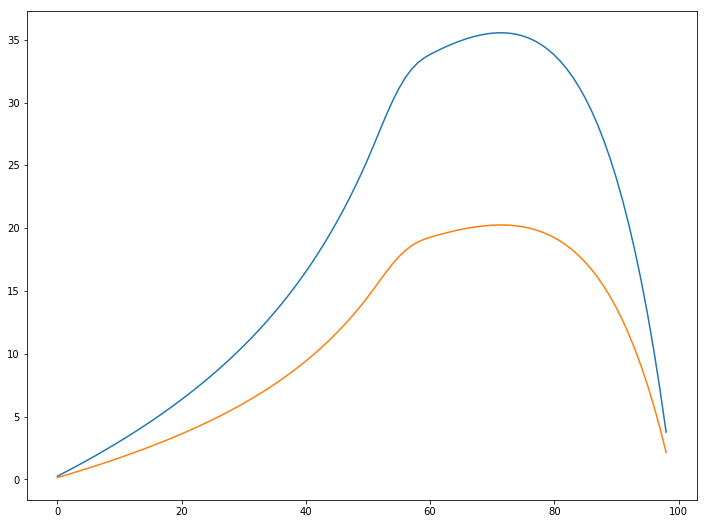

In [68]:
plt.figure(figsize=(12, 9))
plt.plot(range(len(bvec_h)), bvec_h)
plt.plot(range(len(bvec_f)), bvec_f)
plt.show()